In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
# os.environ['USE_PYGEOS'] = '0'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
# import constants as c
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
# define scenario
scenario_name = 'Seattle'
input_dir = 'inputs_' + scenario_name
output_dir = 'outputs_' + scenario_name
plot_dir = 'plots_' + scenario_name
region_code = [411, 531, 532, 539]
focus_region = 531
lehd_file = 'WA_naics.csv'
map_file = scenario_name + '_freight.geojson'

In [3]:
synthfirm_all = read_csv(os.path.join(output_dir, 'synthetic_firms.csv'))
region_map = gpd.read_file(os.path.join(input_dir, map_file))
mesozone_id_lookup = read_csv(os.path.join(input_dir, 'zonal_id_lookup_final.csv'))
lehd_validation = read_csv(os.path.join(input_dir, lehd_file))
synthfirm_output = read_csv(os.path.join(output_dir, 'processed_b2b_flow_summary_mesozone.csv'))
region_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry
0,530559601001,53055,3312.0,"MULTIPOLYGON (((-122.92181 48.75483, -122.9204..."
1,530330293053,53033,1923.0,"MULTIPOLYGON (((-122.21485 47.42306, -122.2075..."
2,530330205002,53033,1429.0,"MULTIPOLYGON (((-122.31348 47.75574, -122.3133..."
3,530770028021,53077,4720.0,"MULTIPOLYGON (((-120.67101 46.54639, -120.6498..."
4,530530620003,53053,2850.0,"MULTIPOLYGON (((-122.42057 47.22859, -122.4208..."


In [4]:
# calculate land area
region_map.loc[:, "area"] = \
region_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 
# sf_map.loc[:, "area"] = sf_map.area/ 10**6 # km^2
region_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area
0,530559601001,53055,3312.0,"MULTIPOLYGON (((-122.92181 48.75483, -122.9204...",64.302652
1,530330293053,53033,1923.0,"MULTIPOLYGON (((-122.21485 47.42306, -122.2075...",0.891907
2,530330205002,53033,1429.0,"MULTIPOLYGON (((-122.31348 47.75574, -122.3133...",0.435127
3,530770028021,53077,4720.0,"MULTIPOLYGON (((-120.67101 46.54639, -120.6498...",11.053390
4,530530620003,53053,2850.0,"MULTIPOLYGON (((-122.42057 47.22859, -122.4208...",0.291051


In [9]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, 
                        on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')
firm_count            8396663.0
employment_count    107567988.0
dtype: float64


,MESOZONE,firm_count,employment_count,GEOID,CBPZONE,FAFID,FAFNAME
0,1.0,25,155.764867,530019501001,53001,539,Rest of WA
1,2.0,34,194.530916,530019501002,53001,539,Rest of WA
2,3.0,46,370.999530,530019501003,53001,539,Rest of WA
3,4.0,14,132.657083,530019502001,53001,539,Rest of WA
4,5.0,30,158.772014,530019502002,53001,539,Rest of WA


In [10]:
# select synthetic firms within study area
firm_in_study_area = \
firm_by_zone.loc[firm_by_zone['FAFID'].isin(region_code)]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

synthfirm_in_study_area.head(5)

287464
3549093.0
458
385


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE
8109199,41003,411,1,111300,3,1.0,7457574,4803.0
8109200,41003,411,1,111300,3,1.0,7457575,4807.0
8109201,41003,411,1,111300,3,1.0,7457576,4762.0
8109202,41003,411,1,111300,3,1.0,7460076,4799.0
8109203,41003,411,1,111300,3,1.0,7460077,4792.0


In [14]:
# get synthetic firms by county
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
firm_in_study_area_by_county.head(5)

,CBPZONE,employment_count
0,41003,19164.0
1,41005,131202.0
2,41009,5110.0
3,41043,27620.0
4,41047,113944.0


In [16]:
# compare to LEHD data
lehd_validation.head(5)
print(lehd_validation.columns)

list_of_attr = ['n11', 'n21', 'n22', 'n23', 'n3133', 'n42',
                'n4445', 'n4849', 'n51', 'n52', 'n53', 'n54', 
                'n55', 'n56', 'n61', 'n62', 'n71', 'n72', 'n81', 'n92']
lehd_validation = pd.merge(lehd_validation,mesozone_id_lookup,
                               on = 'GEOID', how = 'left')
lehd_validation.loc[:, 'total'] = lehd_validation.loc[:, list_of_attr].sum(axis = 1)
lehd_validation.head(5)


Index(['GEOID', 'metalayer_id', 'n11', 'n21', 'n22', 'n23', 'n3133', 'n42',
       'n4445', 'n4849', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n61',
       'n62', 'n71', 'n72', 'n81', 'n92'],
      dtype='object')


,GEOID,metalayer_id,n11,n21,n22,n23,n3133,n42,n4445,n4849,...,n62,n71,n72,n81,n92,CBPZONE,MESOZONE,FAFID,FAFNAME,total
0,530019501001,53001950,36,0,0,0,0,10,9,0,...,0,0,1,0,0,53001.0,1.0,539.0,Rest of WA,58
1,530019501002,53001950,2,0,0,7,0,11,26,0,...,107,0,150,2,1,53001.0,2.0,539.0,Rest of WA,404
2,530019501003,53001950,1,0,3,2,7,33,40,5,...,8,1,11,16,241,53001.0,3.0,539.0,Rest of WA,424
3,530019502001,53001950,19,0,0,0,2,0,8,0,...,0,1,2,0,5,53001.0,4.0,539.0,Rest of WA,72
4,530019502002,53001950,13,0,0,2,0,1,7,22,...,1,8,0,0,13,53001.0,5.0,539.0,Rest of WA,120


4492024
3549092.9999999995
35680.4 0.97


,County,LEHD employment,SynthFirm employment
0,41003.0,38589,19164.0
1,41005.0,166293,131202.0
2,41009.0,10894,5110.0
3,41043.0,45360,27620.0
4,41047.0,154094,113944.0


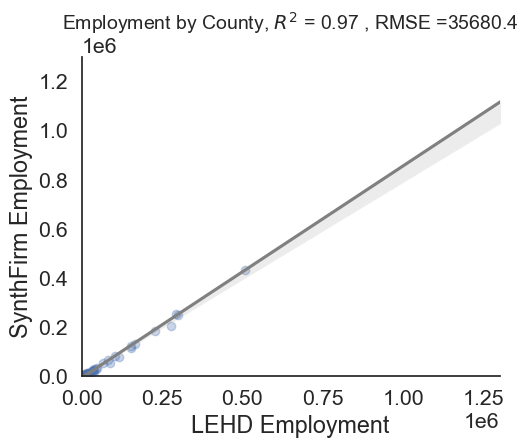

In [29]:
lehd_firm_by_county = lehd_validation.groupby('CBPZONE')[['total']].sum()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# # print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_county['LEHD employment'], 
                              firm_comparison_by_county['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_county['LEHD employment'], 
                  firm_comparison_by_county['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_county['LEHD employment'].sum())
print(firm_comparison_by_county['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('seaborn-v0_8-white')
# plt.rcParams['axes.facecolor'] = 'white'
sns.set(font_scale=1.4)  # crazy big
sns.set_style("white")
sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
    scatter_kws = {'alpha':0.3})
# g.set_facecolor("white")

plt.xlim([0, 1300000])
plt.ylim([0, 1300000])
plt.xlabel('LEHD Employment')
plt.ylabel('SynthFirm Employment')
plt.title('Employment by County, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_county_validation.png'), dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_county.head(5)

4492024
3549093.0
['11' '21' '23' '31' '32' '33' '42' '44' '45' '48' '49' '4A' '51' '52'
 '53' '54' '55' '56' '61' '62' '71' '72' '81' 'S0' '22']


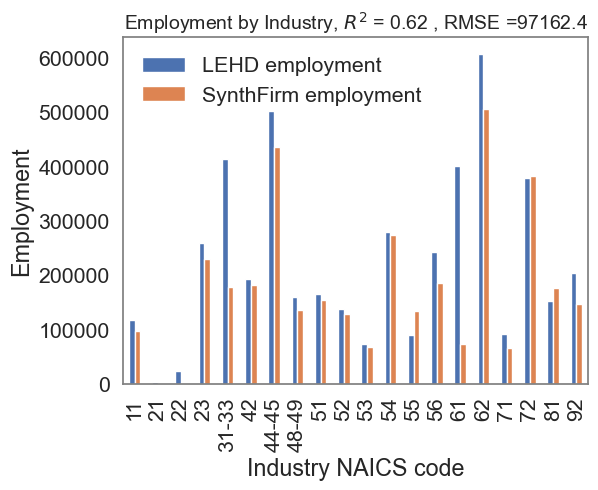

In [30]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = pd.melt(lehd_validation, id_vars = 'CBPZONE',
                               value_vars=list_of_attr, 
                                var_name='industry', value_name='emp')

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry.loc[:, 'industry'] = \
lehd_firm_by_industry.loc[:, 'industry'].str.split('n').str[1]

lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '3133', 'industry'] = '31-33'
lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '4445', 'industry'] = '44-45'
lehd_firm_by_industry.loc[lehd_firm_by_industry['industry'] == '4849', 'industry'] = '48-49'
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['CBPZONE'].isin(selected_counties)]


lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['emp']].sum()
print(lehd_firm_by_industry['emp'].sum())
# lehd_firm_by_industry.head(5)
print(synthfirm_in_study_area.loc[:, 'Emp'].sum())
synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
print(synthfirm_in_study_area.loc[:, 'NAICS2'].unique())
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_industry['LEHD employment'], 
                              firm_comparison_by_industry['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_industry['LEHD employment'], 
                  firm_comparison_by_industry['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)

# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")
sns.set(font_scale=1.4)  # crazy big
fig, ax = plt.subplots(figsize = (6,4.5))
ax.set(facecolor = "white")
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry", ax = ax)
plt.xlabel('Industry NAICS code')
plt.ylabel('Employment')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
# plt.grid(color='gray')
# ax.patch.set_edgecolor('black')  

# ax.patch.set_linewidth(1)  
plt.title('Employment by Industry, $R^{2}$ = ' + str(r2_emp) + \
          ' , RMSE =' + str(rmse_emp), fontsize = 14)
plt.savefig(os.path.join(plot_dir, 'emp_by_industry_validation.png'), dpi = 200, 
            bbox_inches = 'tight')

# firm_in_study_area_by_industry

In [32]:
firm_in_region = firm_by_zone.loc[firm_by_zone['FAFID'].isin([focus_region])]
region_map_with_firm = region_map.merge(firm_in_region, on='MESOZONE', how='inner')
region_map_with_firm.loc[:, 'firm_per_area'] = \
region_map_with_firm.loc[:, 'firm_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.loc[:, 'emp_per_area'] = \
region_map_with_firm.loc[:, 'employment_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,area,firm_count,employment_count,GEOID_y,CBPZONE_y,FAFID,FAFNAME,firm_per_area,emp_per_area
0,530330293053,53033,1923.0,"MULTIPOLYGON (((-122.21485 47.42306, -122.2075...",0.891907,22,132.739911,530330293053,53033,531,Seattle,24.666245,148.827053
1,530330205002,53033,1429.0,"MULTIPOLYGON (((-122.31348 47.75574, -122.3133...",0.435125,48,477.373410,530330205002,53033,531,Seattle,110.313074,1097.094343
2,530530620003,53053,2850.0,"MULTIPOLYGON (((-122.42057 47.22859, -122.4208...",0.291052,9,268.820510,530530620003,53053,531,Seattle,30.922265,923.615439
3,530530613002,53053,2824.0,"MULTIPOLYGON (((-122.46008 47.25006, -122.4529...",0.254453,44,445.331643,530530613002,53053,531,Seattle,172.919636,1750.149672
4,530610527055,53061,3798.0,"MULTIPOLYGON (((-122.14092 48.04772, -122.1335...",0.595702,2,9.804519,530610527055,53061,531,Seattle,3.357385,16.458773


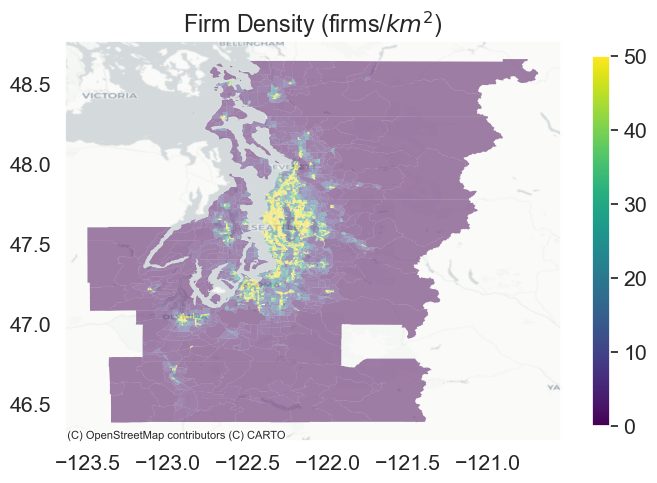

In [34]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'firm_per_area', 
                           vmin=0, vmax=50, alpha = 0.5, legend=True,
                              cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.8}, edgecolor='none')
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
ax.grid(False)
plt.title('Firm Density (firms/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'region_firm_count.png'), dpi = 300)

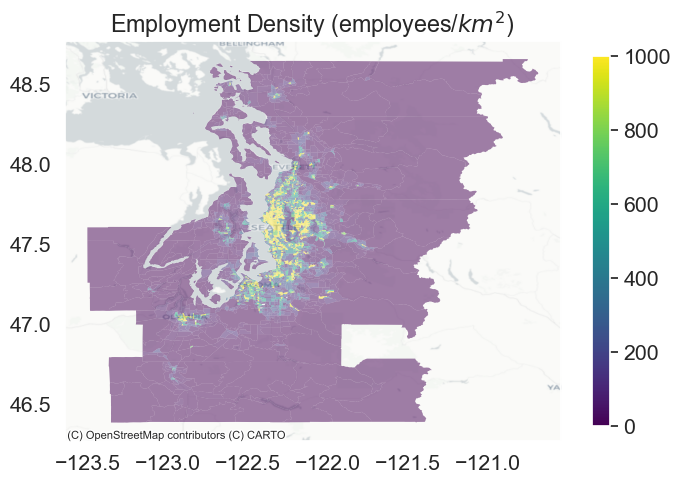

In [36]:
ax = region_map_with_firm.plot(figsize = (8,6), column = 'emp_per_area', 
                            vmin=0, vmax=1000, alpha = 0.5, legend=True,
                               cmap='viridis',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.8}, edgecolor='none')
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Employment Density (employees/$km^{2}$)')
ax.grid(False)
plt.savefig(os.path.join(plot_dir, 'region_emp_count.png'), dpi = 300)

In [6]:
# plot production
print(synthfirm_output.columns)
production_in_region = synthfirm_output.loc[synthfirm_output['orig_FAFID'].isin([focus_region])]
production_in_region = production_in_region.groupby(['SellerZone'])[['ShipmentLoad']].sum()
production_in_region = production_in_region.reset_index()
production_in_region = production_in_region.rename(columns = {'SellerZone': 'MESOZONE'})

region_map_with_production = \
region_map.merge(production_in_region, on='MESOZONE', how='inner')
region_map_with_production.loc[:, 'production_per_area'] = \
region_map_with_production.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_production.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_production.head(5)

Index(['Unnamed: 0', 'SellerZone', 'orig_FAFID', 'orig_FAFNAME', 'BuyerZone',
       'dest_FAFID', 'dest_FAFNAME', 'SCTG_Group', 'SCTG_Name', 'mode_choice',
       'tmiles', 'ShipmentLoad', 'count', 'outbound', 'inbound', 'Distance'],
      dtype='object')


,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,production_per_area
0,530330293053,53033,1923.0,"MULTIPOLYGON (((-122.21485 47.42306, -122.2075...",0.891907,19.843360,20.183260
1,530330205002,53033,1429.0,"MULTIPOLYGON (((-122.31348 47.75574, -122.3133...",0.435127,13.527352,28.202814
2,530330105001,53033,1329.0,"MULTIPOLYGON (((-122.38153 47.55563, -122.3799...",0.266125,29.618735,100.966167
3,530330053012,53033,1118.0,"MULTIPOLYGON (((-122.31764 47.66130, -122.3119...",0.203044,16.809808,75.104841
4,530530713073,53053,3003.0,"MULTIPOLYGON (((-122.35733 47.13985, -122.3361...",2.611505,30.926287,10.743176


<Axes: >

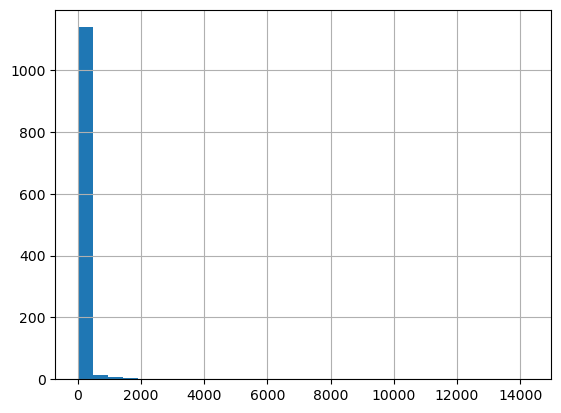

In [11]:
region_map_with_production['production_per_area'].hist(bins= 30)

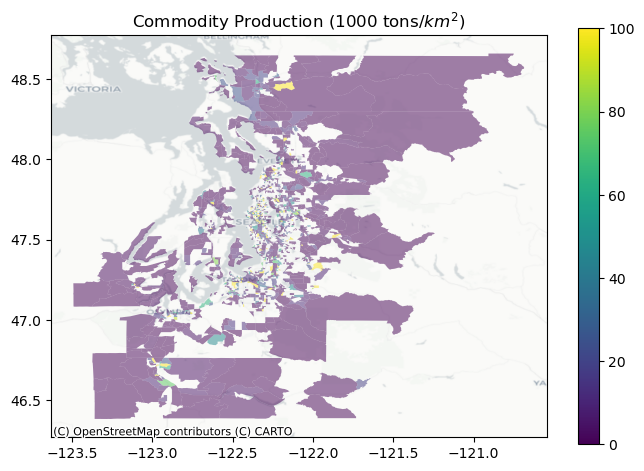

In [15]:
ax = region_map_with_production.plot(figsize = (8,6), column = 'production_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 100,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_production.production_per_area.min(), 
                            #                                vmax=region_map_with_production.production_per_area.max()),
                            cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.9})
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)

ax.grid(False)
plt.title('Commodity Production (1000 tons/$km^{2}$)')
plt.savefig(os.path.join(plot_dir, 'region_production_allmodes.png'), dpi = 300)

In [16]:
# print(synthfirm_output.columns)
attraction_in_region = synthfirm_output.loc[synthfirm_output['dest_FAFID'].isin([focus_region])]
attraction_in_region = attraction_in_region.groupby(['BuyerZone'])[['ShipmentLoad']].sum()
attraction_in_region = attraction_in_region.reset_index()
attraction_in_region = attraction_in_region.rename(columns = {'BuyerZone': 'MESOZONE'})

region_map_with_attraction = \
region_map.merge(attraction_in_region, on='MESOZONE', how='inner')
region_map_with_attraction.loc[:, 'attraction_per_area'] = \
region_map_with_attraction.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_attraction.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_attraction.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,attraction_per_area
0,530330293053,53033,1923.0,"MULTIPOLYGON (((-122.21485 47.42306, -122.2075...",0.891907,96.087241,97.733133
1,530330205002,53033,1429.0,"MULTIPOLYGON (((-122.31348 47.75574, -122.3133...",0.435127,58.435121,121.829821
2,530530620003,53053,2850.0,"MULTIPOLYGON (((-122.42057 47.22859, -122.4208...",0.291051,0.988487,3.081045
3,530530613002,53053,2824.0,"MULTIPOLYGON (((-122.46008 47.25006, -122.4529...",0.254453,9.421714,33.590605
4,530610527055,53061,3798.0,"MULTIPOLYGON (((-122.14092 48.04772, -122.1335...",0.595708,0.517992,0.788834


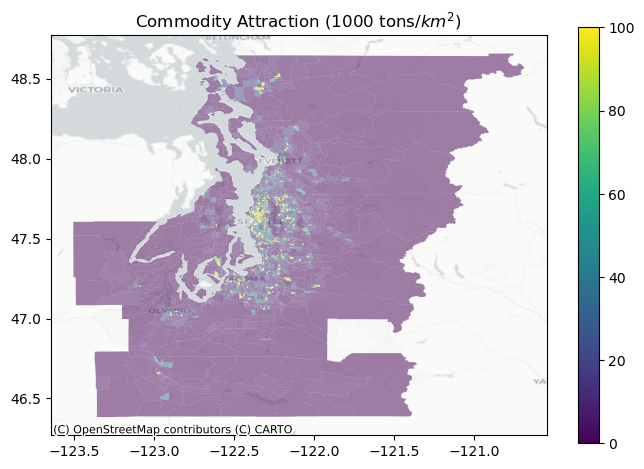

In [17]:
ax = region_map_with_attraction.plot(figsize = (8,6), column = 'attraction_per_area', 
                            alpha = 0.5, legend=True,
                            vmin = 0, vmax = 100,
                            # norm=matplotlib.colors.LogNorm(vmin=region_map_with_attraction.attraction_per_area.min(), 
                            #                                vmax=region_map_with_attraction.attraction_per_area.max()),
                                    cmap='viridis',
                            linewidth=0.01, 
                            legend_kwds = {'shrink': 0.9})
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Commodity Attraction (1000 tons/$km^{2}$)')
ax.grid(False)
plt.savefig(os.path.join(plot_dir, 'region_attraction_allmodes.png'), dpi = 200)